Author: Geoff Boeing

Web: http://geoffboeing.com

Description: This notebook reduces the size of a spatial data set by clustering with DBSCAN. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from time import time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle

In [2]:
# load the data set
df = pd.read_csv('data/summer-travel-gps-full.csv')
coordinates = df.as_matrix(columns=['lon', 'lat'])
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


In [3]:
# Compute DBSCAN
# eps is the physical distance from each point that forms its ε-neighborhood
# min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise
start_time = time()
db = DBSCAN(eps=.01, min_samples=1).fit(coordinates)
labels = db.labels_

# number of clusters in labels, ignoring noise if present
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print 'Estimated number of clusters: {}'.format(num_clusters)
print 'Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coordinates, labels))
print 'Process took {:.02f} seconds'.format(time()-start_time)

Estimated number of clusters: 158
Silhouette coefficient: 0.717
Process took 2.78 seconds


In [4]:
def plotClusters():
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # for each label (aka index) in the set of unique labels
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        # boolean array as a mask for all labels that match the current one in the loop
        class_member_mask = (labels == k)

        # the xy point pairs from the original data set that match this cluster
        xy = coordinates[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

        # and the inverse
        xy = coordinates[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [5]:
# return the coordinates of the centroid of a numpy array of coordinate points
def getCentroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

In [6]:
# return the point from a set of points that is nearest to the specified point of reference
def getNearestPoint(set_of_points, point_of_reference):
    
    closest_point = None
    closest_dist = None
    
    for point in set_of_points:        
        
        # calculate the great circle distance between points            
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        
        # if this row's nearest is currently null, save this point as its nearest
        # or if this distance is smaller than the previous smallest, update the row
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    
    return closest_point

In [7]:
# now we take one point's coordinates from each cluster that formed
# first, get the clusters
start_time = time()
clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])

lat = []
lon = []

# for each cluster, find one representative point from the data set
for _, cluster in clusters.iteritems():
    
    if len(cluster) < 3:
        # if there are only one or two points in the cluster,
        # then just take the first coordinate pair that appears in the cluster's array
        representative_point = (cluster[0][1], cluster[0][0])
        
    else:
        # otherwise, find the point in the cluster that is closest to its centroid
        representative_point = getNearestPoint(cluster, getCentroid(cluster))
    
    lat.append(representative_point[0])
    lon.append(representative_point[1])

cl = pd.DataFrame({'lon':lon, 'lat':lat})
print 'process took %s seconds' % round(time() - start_time, 2)
print len(cl), 'rows in the reduced data set'
cl.head()

process took 0.03 seconds
158 rows in the reduced data set


,lat,lon
0,51.478199,-0.446081
1,38.781775,-9.137544
2,38.771939,-9.128911
3,38.742987,-9.147780
4,38.712325,-9.137434


In [8]:
# return the rows from full_set that have matching 'lat' 'lon' coordinates in the simplified_set
def getMatchingRows(full_set, simplified_set):
    
    start_time = time()
    simplified_set['fs_index'] = None

    # fs_index will contain the index of the matching row from the full set
    simplified_set['fs_index'] = None

    # for each coordinate pair in the simplified set
    for si_label, si_row in simplified_set.iterrows():

        si_coords = (si_row['lat'], si_row['lon'])
        # for each coordinate pair in the original full data set
        for fs_label, fs_row in full_set.iterrows():

            # compare tuples of coordinates, if the points match, save this row's index as the matching one
            if si_coords == (fs_row['lat'], fs_row['lon']):
                simplified_set.loc[si_label, 'fs_index'] = fs_label
                break

    # select the rows from the original full data set whose indices appear in fs_index column of the simplified set
    result = full_set.ix[simplified_set['fs_index'].dropna()]
    print 'process took %s seconds' % round(time() - start_time, 2)
    return result

In [9]:
rs = getMatchingRows(df, cl)

process took 7.98 seconds


In [10]:
rs.sort_index(inplace=True)
#rs.to_csv('data/summer-travel-gps-dbscan.csv', index=False)

print 'number of points:', len(rs.index)
rs.tail()

number of points: 158


,lat,lon,date,city,country
1663,40.984723,28.831658,07/06/2014 21:43,Istanbul,Turkey
1664,41.001629,28.949191,07/06/2014 21:58,Istanbul,Turkey
1695,41.014963,29.010762,07/07/2014 16:56,Istanbul,Turkey
1726,41.033193,28.982041,07/08/2014 15:30,Istanbul,Turkey
1756,48.356285,11.791710,07/09/2014 13:17,Munich,Germany


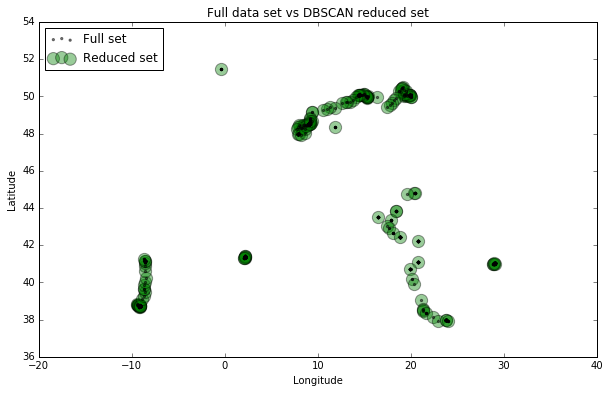

In [11]:
# plot the final reduced set of coordinate points vs the original full set
plt.figure(figsize=(10, 6), dpi=100)
rs_scatter = plt.scatter(rs['lon'], rs['lat'], c='g', alpha=.4, s=150)
df_scatter = plt.scatter(df['lon'], df['lat'], c='k', alpha=.5, s=5)

plt.title('Full data set vs DBSCAN reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()